working/
    .virtual_documents/



image 1/1 /kaggle/input/imagetes/video_20230131_145825_00029_jpg.rf.4e4709b4880012206f6ecd0a4f26465b.jpg: 640x640 1 cap, 1 shell, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


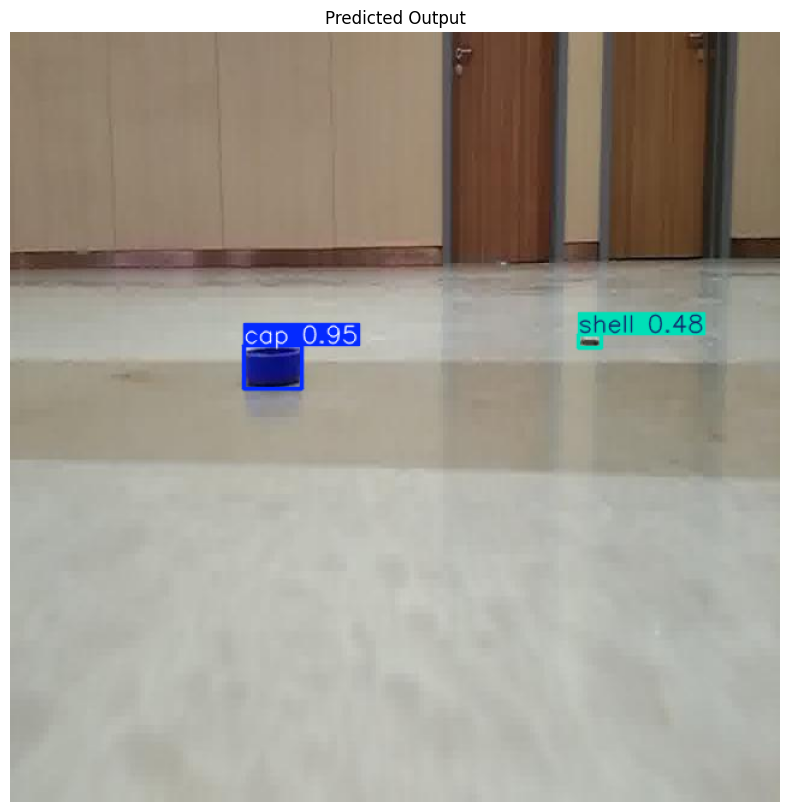

Detection details:
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 3.], device='cuda:0')
conf: tensor([0.9476, 0.4814], device='cuda:0')
data: tensor([[1.9409e+02, 2.6022e+02, 2.4293e+02, 2.9614e+02, 9.4763e-01, 0.0000e+00],
        [4.7205e+02, 2.5189e+02, 4.9118e+02, 2.6239e+02, 4.8141e-01, 3.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([2, 6])
xywh: tensor([[218.5103, 278.1834,  48.8412,  35.9226],
        [481.6160, 257.1401,  19.1270,  10.4957]], device='cuda:0')
xywhn: tensor([[0.3414, 0.4347, 0.0763, 0.0561],
        [0.7525, 0.4018, 0.0299, 0.0164]], device='cuda:0')
xyxy: tensor([[194.0897, 260.2221, 242.9309, 296.1447],
        [472.0525, 251.8922, 491.1794, 262.3880]], device='cuda:0')
xyxyn: tensor([[0.3033, 0.4066, 0.3796, 0.4627],
        [0.7376, 0.3936, 0.7675, 0.4100]], device='cuda:0')


In [8]:
# import cv2
# import matplotlib.pyplot as plt

# # Specify the path to your input image
# input_image_path = "/kaggle/input/imagetes/video_20230131_145825_00029_jpg.rf.4e4709b4880012206f6ecd0a4f26465b.jpg"  # Update with your image path

# # Run the model prediction on the input image
# # You can adjust the confidence threshold (e.g., conf=0.25) as needed
# results = model.predict(source=input_image_path, conf=0.25, show=False)

# # The 'results' object is a list; for a single image, we access the first element.
# result = results[0]

# # Get the annotated image (with bounding boxes and labels) from the result.
# # The 'plot()' method returns the annotated image.
# annotated_image = result.plot()

# # Display the annotated image using matplotlib
# plt.figure(figsize=(10, 10))
# # OpenCV uses BGR by default, so we convert it to RGB for correct display
# plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.title("Predicted Output")
# plt.show()

# # Optionally, print the detection details such as bounding boxes, classes, and confidence scores.
# print("Detection details:")
# print(result.boxes)


In [6]:
# # Uncomment these if you're running in a new environment to ensure packages are installed:
# # !pip install ultralytics
# # !pip install ray==2.0.0

# # -------------------------------
# # 1. Patch Ray to Avoid _get_session Error
# # -------------------------------
# try:
#     import ray
#     try:
#         # Try to import the session module from ray.train._internal
#         import ray.train._internal.session as session
#         # If the _get_session attribute does not exist, add a dummy version that returns None.
#         if not hasattr(session, "_get_session"):
#             session._get_session = lambda: None
#             print("Ray patch applied: _get_session has been set to a dummy function.")
#         else:
#             print("ray.train._internal.session already has _get_session.")
#     except Exception as inner_error:
#         print("Could not patch ray.train._internal.session:", inner_error)
# except ImportError:
#     print("Ray is not installed. Skipping ray patching.")

# # -------------------------------
# # 2. Imports and Dataset Setup
# # -------------------------------
# import os
# import torch
# import yaml
# from pathlib import Path
# from ultralytics import YOLO

# # Set the dataset path (adjust as necessary; this example is for Kaggle)
# DATASET_PATH = "/kaggle/input/wastet"

# # Create a data.yaml configuration file with absolute paths
# data_yaml = {
#     'train': f"{DATASET_PATH}/train/images",
#     'val': f"{DATASET_PATH}/valid/images",
#     'test': f"{DATASET_PATH}/test/images",
#     'nc': 4,
#     'names': ['cap', 'paper', 'plastic', 'shell']
# }

# # Write the data.yaml file
# with open('data.yaml', 'w') as f:
#     yaml.dump(data_yaml, f)

# print("Data configuration saved in data.yaml:")
# with open('data.yaml', 'r') as f:
#     print(f.read())

# # Verify dataset paths
# print("Verifying paths:")
# print("Train path exists:", os.path.exists(data_yaml['train']))
# print("Validation path exists:", os.path.exists(data_yaml['val']))
# print("Test path exists:", os.path.exists(data_yaml['test']))

# # Check for GPU availability
# print("\nGPU Available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # -------------------------------
# # 3. Initialize and Train YOLOv8 Model
# # -------------------------------
# # Initialize YOLOv8 model with a pretrained weight file (you can use 'yolov8n.pt' for fine-tuning)
# model = YOLO('yolov8n.pt')

# # Training configuration
# train_args = {
#     'data': str(Path('data.yaml').absolute()),  # Use absolute path to data.yaml
#     'epochs': 50,
#     'imgsz': 640,
#     'batch': 8,
#     'patience': 20,
#     'device': 0,         # Use GPU if available (0 indicates first GPU)
#     'workers': 2,
#     'save': True,
#     'cache': True,
#     'project': 'waste_detection',
#     'name': 'training_run',
#     'exist_ok': True
# }

# print("\nStarting training...")
# # Train the model with keyword arguments. The patched Ray callback should now be safe.
# model.train(**train_args)
# print("Training completed successfully!")

# # -------------------------------
# # 4. Save the Trained Model
# # -------------------------------
# model_save_path = 'waste_detection_best.pt'
# model.save(model_save_path)
# print(f"\nModel saved successfully as {model_save_path}")

# # Verify that the model file exists by listing its details
# print("\nSaved model file details:")
# !ls -lh {model_save_path}


Ray patch applied: _get_session has been set to a dummy function.
Data configuration saved in data.yaml:
names:
- cap
- paper
- plastic
- shell
nc: 4
test: /kaggle/input/wastet/test/images
train: /kaggle/input/wastet/train/images
val: /kaggle/input/wastet/valid/images

Verifying paths:
Train path exists: True
Validation path exists: True
Test path exists: True

GPU Available: True
GPU Name: Tesla T4

Starting training...
Ultralytics 8.3.73 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=2, project=waste_detection, name=training_run, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap

train: Scanning /kaggle/input/wastet/train/labels... 7349 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7349/7349 [00:08<00:00, 896.28it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/wastet/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 12120. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (8.4GB RAM): 100%|██████████| 7349/7349 [00:10<00:00, 711.11it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/wastet/valid/labels... 526 images, 0 backgrounds, 0 corrupt: 100%|██████████| 526/526 [00:00<00:00, 692.07it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/wastet/valid is not writeable, cache not saved.


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.6GB RAM): 100%|██████████| 526/526 [00:00<00:00, 690.95it/s]


Plotting labels to waste_detection/training_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to waste_detection/training_run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.57G     0.9167      1.838      0.963          8        640: 100%|██████████| 919/919 [01:33<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.37it/s]

                   all        526       1164      0.522      0.449      0.431      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.32G     0.8104     0.9304     0.9446          9        640: 100%|██████████| 919/919 [01:29<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.99it/s]

                   all        526       1164       0.52      0.564      0.455      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.28G     0.7802     0.7627     0.9356          5        640: 100%|██████████| 919/919 [01:27<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.71it/s]


                   all        526       1164      0.523      0.537       0.49      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.29G     0.7344     0.6805     0.9229         14        640: 100%|██████████| 919/919 [01:27<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.68it/s]


                   all        526       1164      0.487       0.62      0.491      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.28G     0.6944     0.6269     0.9118          7        640: 100%|██████████| 919/919 [01:27<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.74it/s]

                   all        526       1164      0.519      0.627      0.531      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.28G     0.6585     0.5825     0.9054          8        640: 100%|██████████| 919/919 [01:27<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.42it/s]

                   all        526       1164      0.576      0.589      0.546      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.29G     0.6404     0.5456     0.9003         16        640: 100%|██████████| 919/919 [01:26<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.85it/s]

                   all        526       1164      0.553      0.555      0.531      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.28G     0.6146     0.5276     0.8911         13        640: 100%|██████████| 919/919 [01:27<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.82it/s]

                   all        526       1164      0.597      0.571      0.526      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.29G     0.6049     0.5014     0.8889         11        640: 100%|██████████| 919/919 [01:27<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.88it/s]


                   all        526       1164      0.587      0.605      0.567      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.28G     0.5782     0.4781     0.8792         16        640: 100%|██████████| 919/919 [01:27<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.69it/s]

                   all        526       1164      0.621      0.594      0.572      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.28G     0.5622     0.4706     0.8766          8        640: 100%|██████████| 919/919 [01:27<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.83it/s]

                   all        526       1164      0.588       0.65      0.592      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.28G     0.5596     0.4599     0.8738          4        640: 100%|██████████| 919/919 [01:26<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.44it/s]

                   all        526       1164      0.609      0.601      0.563      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.29G     0.5529     0.4559     0.8746         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.43it/s]

                   all        526       1164      0.564      0.646      0.571       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.28G      0.541     0.4399     0.8645         10        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.73it/s]

                   all        526       1164      0.608      0.621      0.581      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.28G     0.5252     0.4242     0.8658         12        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.96it/s]

                   all        526       1164       0.64      0.642      0.579      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.28G     0.5201     0.4206     0.8649          9        640: 100%|██████████| 919/919 [01:27<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.59it/s]

                   all        526       1164      0.628       0.57       0.57      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.29G     0.5109     0.4164     0.8641         11        640: 100%|██████████| 919/919 [01:27<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.62it/s]

                   all        526       1164      0.539      0.615      0.552      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.29G        0.5     0.4032      0.856         21        640: 100%|██████████| 919/919 [01:27<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.55it/s]

                   all        526       1164      0.617      0.644      0.573      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.28G      0.495     0.3937     0.8572          4        640: 100%|██████████| 919/919 [01:26<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.93it/s]

                   all        526       1164      0.632      0.642      0.592      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.29G     0.4853     0.3866     0.8599         17        640: 100%|██████████| 919/919 [01:26<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.78it/s]

                   all        526       1164      0.605      0.635      0.584      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.28G     0.4814     0.3826     0.8541          8        640: 100%|██████████| 919/919 [01:27<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.51it/s]

                   all        526       1164      0.678      0.598       0.62      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.29G      0.482     0.3787     0.8554         20        640: 100%|██████████| 919/919 [01:28<00:00, 10.44it/s]
      23/50      1.29G     0.4645     0.3677     0.8518         13        640: 100%|██████████| 919/919 [01:27<00:00, 10.49it/s]0.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.92it/s]

                   all        526       1164      0.578      0.695      0.605      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.28G      0.464     0.3588     0.8482          5        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.88it/s]

                   all        526       1164      0.621      0.632      0.591      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.29G     0.4462     0.3532     0.8454         10        640: 100%|██████████| 919/919 [01:27<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.46it/s]

                   all        526       1164      0.609      0.663      0.623      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.29G     0.4444     0.3468     0.8461         17        640: 100%|██████████| 919/919 [01:26<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.67it/s]

                   all        526       1164      0.616      0.706      0.626      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.28G     0.4357     0.3374     0.8445          6        640: 100%|██████████| 919/919 [01:28<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.28it/s]


                   all        526       1164      0.621      0.641      0.627      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.29G     0.4318     0.3369     0.8439         21        640: 100%|██████████| 919/919 [01:27<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.76it/s]


                   all        526       1164       0.63      0.662      0.613      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.28G     0.4304     0.3317     0.8433          9        640: 100%|██████████| 919/919 [01:26<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.95it/s]

                   all        526       1164       0.62      0.694      0.617      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.28G       0.43     0.3285     0.8433         11        640: 100%|██████████| 919/919 [01:26<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.98it/s]

                   all        526       1164      0.612      0.701      0.613      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.28G     0.4204     0.3205     0.8387          6        640: 100%|██████████| 919/919 [01:26<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.79it/s]

                   all        526       1164      0.626      0.677      0.643      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.28G     0.4203     0.3174     0.8399         19        640: 100%|██████████| 919/919 [01:27<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.69it/s]

                   all        526       1164        0.6      0.648      0.621      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.28G     0.4066     0.3109      0.836         11        640: 100%|██████████| 919/919 [01:26<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.37it/s]

                   all        526       1164      0.616       0.68      0.604      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.28G     0.4035     0.3047     0.8364         12        640: 100%|██████████| 919/919 [01:26<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.63it/s]

                   all        526       1164      0.633      0.632      0.625      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.29G     0.4014     0.3032     0.8379          8        640: 100%|██████████| 919/919 [01:27<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.87it/s]

                   all        526       1164      0.668      0.625      0.634       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.28G     0.3984      0.299     0.8359          4        640: 100%|██████████| 919/919 [01:27<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.97it/s]

                   all        526       1164      0.646      0.645       0.64      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.29G      0.393     0.2919     0.8332         16        640: 100%|██████████| 919/919 [01:27<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.93it/s]

                   all        526       1164      0.601      0.652      0.605      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.29G     0.3836     0.2895     0.8299          8        640: 100%|██████████| 919/919 [01:26<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.47it/s]

                   all        526       1164       0.63      0.656      0.621      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.28G     0.3889     0.2898     0.8332         12        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.77it/s]

                   all        526       1164      0.631       0.64      0.597      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.28G     0.3723     0.2777     0.8287         14        640: 100%|██████████| 919/919 [01:26<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.91it/s]

                   all        526       1164      0.636      0.651      0.624      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.28G     0.8709     0.5345     0.9528          6        640: 100%|██████████| 919/919 [01:25<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.80it/s]

                   all        526       1164      0.651      0.651      0.622      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.28G     0.8421     0.5014     0.9391          7        640: 100%|██████████| 919/919 [01:25<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.74it/s]

                   all        526       1164      0.642      0.654      0.616      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.28G     0.8345      0.479     0.9341          7        640: 100%|██████████| 919/919 [01:25<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.81it/s]

                   all        526       1164      0.677       0.64       0.63      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.28G     0.8181     0.4551     0.9216         11        640: 100%|██████████| 919/919 [01:25<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.83it/s]

                   all        526       1164      0.674      0.655      0.632      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.28G     0.8018     0.4438     0.9147          8        640: 100%|██████████| 919/919 [01:25<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.37it/s]

                   all        526       1164      0.665      0.663      0.631      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.28G     0.7949     0.4348     0.9124          9        640: 100%|██████████| 919/919 [01:25<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.74it/s]

                   all        526       1164      0.665      0.657       0.63      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.28G     0.7852     0.4233     0.9058          5        640: 100%|██████████| 919/919 [01:25<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.43it/s]

                   all        526       1164      0.676      0.629      0.624      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.27G     0.7855     0.4195     0.9065          8        640: 100%|██████████| 919/919 [01:25<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.98it/s]

                   all        526       1164      0.657      0.652      0.627      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.28G     0.7758     0.4125     0.9071          8        640: 100%|██████████| 919/919 [01:25<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.73it/s]

                   all        526       1164      0.656       0.67      0.625      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.28G     0.7696     0.4034     0.9013          7        640: 100%|██████████| 919/919 [01:25<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00, 10.72it/s]

                   all        526       1164      0.686      0.632      0.625      0.444



50 epochs completed in 1.262 hours.
Optimizer stripped from waste_detection/training_run/weights/last.pt, 6.2MB
Optimizer stripped from waste_detection/training_run/weights/best.pt, 6.2MB

Validating waste_detection/training_run/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:03<00:00,  8.48it/s]


                   all        526       1164      0.665      0.658      0.631      0.451
                   cap        365        507      0.982      0.861      0.962      0.744
                 paper        212        285      0.726      0.491      0.554      0.363
               plastic         15         16     0.0818      0.562      0.147      0.111
                 shell        132        356       0.87      0.716       0.86      0.588


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to waste_detection/training_run
Training completed successfully!

Model saved successfully as waste_detection_best.pt

Saved model file details:
-rw-r--r-- 1 root root 6.0M Feb  9 12:42 waste_detection_best.pt


Columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


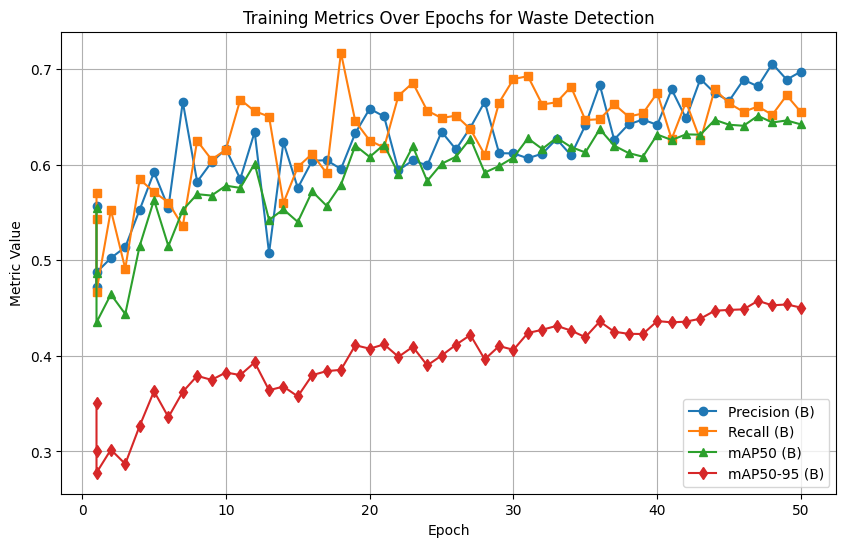

In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load training results from CSV
# results_df = pd.read_csv('/kaggle/working/waste_detection/training_run/results.csv')

# # Print available columns to verify the structure
# print("Columns in results.csv:", results_df.columns.tolist())

# # Create a figure to plot the metrics
# plt.figure(figsize=(10, 6))

# # Plot Precision, Recall, mAP50, and mAP50-95 over epochs using the corresponding columns
# plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision (B)', marker='o')
# plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall (B)', marker='s')
# plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50 (B)', marker='^')
# plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95 (B)', marker='d')

# # Customize the plot
# plt.xlabel('Epoch')
# plt.ylabel('Metric Value')
# plt.title('Training Metrics Over Epochs for Waste Detection')
# plt.legend()
# plt.grid(True)
# plt.show()
